# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [147]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-10-04/data_eval_new/"
file_name = "int_norm_20161004_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [148]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [149]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [150]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

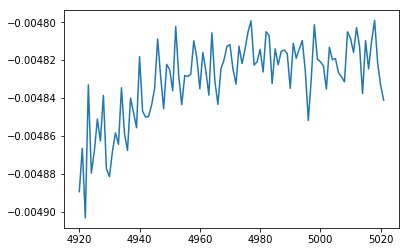

In [151]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

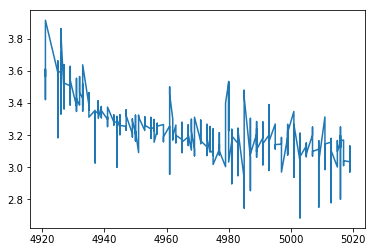

In [152]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

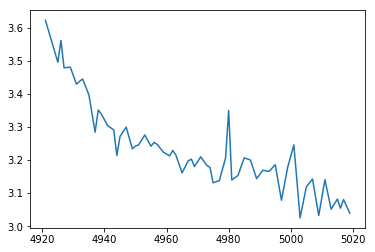

In [153]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

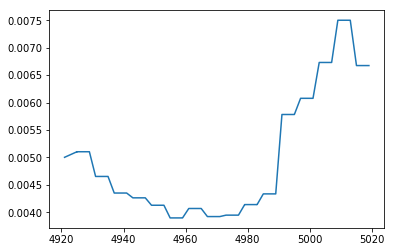

In [154]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [155]:
background_mean = df_mean(background)

# Outlier rejection

In [215]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [216]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [221]:
column = "124/118"
sample = "NIST 200ppb"

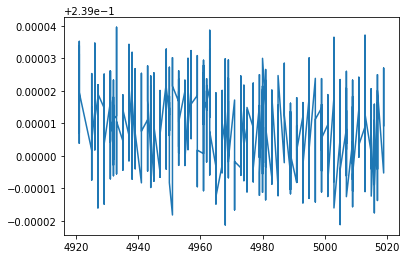

In [222]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [223]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [224]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-10-04 20:41:00,NIST 200ppb,2,1,4921,NaN,NaN,0.013938,0.600300,0.316734,0.354641,1.345918,0.19125,0.239031
2016-10-04 20:41:00,NIST 200ppb,2,2,4921,0.040144,0.027177,0.013938,0.600286,0.316729,0.354637,1.345906,0.19125,0.239018
2016-10-04 20:41:00,NIST 200ppb,2,3,4921,0.040144,0.027181,0.013942,0.600310,0.316726,0.354638,1.345887,0.19125,0.239034
2016-10-04 20:41:00,NIST 200ppb,2,4,4921,0.040144,0.027176,0.013941,0.600300,0.316735,0.354626,1.345871,NaN,0.239016
2016-10-04 20:41:00,NIST 200ppb,2,5,4921,0.040148,0.027184,0.013942,0.600324,0.316744,0.354634,1.345908,NaN,0.239009
2016-10-04 20:41:00,NIST 200ppb,2,6,4921,0.040145,0.027180,0.013944,0.600318,0.316738,0.354637,1.345888,0.19125,0.239013
2016-10-04 20:41:00,NIST 200ppb,2,7,4921,0.040143,0.027172,0.013939,0.600294,0.316738,0.354633,1.345934,0.19125,0.239019
2016-10-04 20:41:00,NIST 200ppb,2,8,4921,0.040141,0.027176,0.013943,0.600308,0.316727,0.354625,1.345907,0.19125,0.239019
2016-10-04 20:41:00,NIST 200ppb,2,9,4921,0.040145,0.027179,0.013945,0.600318,0.316736,0.354624,1.345887,0.19125,0.239025


In [225]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4945        2016-10-05 02:11:00    0.259050
4946        2016-10-05 02:26:00    0.258783
            2016-10-05 02:26:00    0.258737
            2016-10-05 02:26:00    0.258789
4949        2016-10-05 03:05:00    0.259333
4958        2016-10-05 05:12:00    0.259434
4987        2016-10-05 11:58:00    0.258122
            2016-10-05 11:58:00    0.258102
4988        2016-10-05 12:13:00    0.258065
4994        2016-10-05 13:38:00    0.257956
            2016-10-05 13:38:00    0.258408
5005        2016-10-05 16:11:00    0.258306
5016        2016-10-05 18:46:00    0.257978
5017        2016-10-05 19:01:00    0.258360
            2016-10-05 19:01:00    0.258337
Name: 124/118, dtype: float64

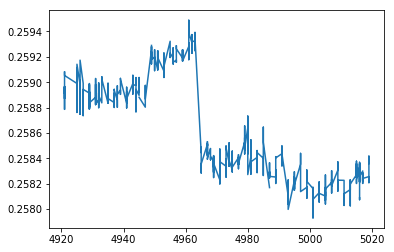

In [226]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [227]:
df[df["Sample"] == sample][column].std()

0.0003974900928907713

In [228]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

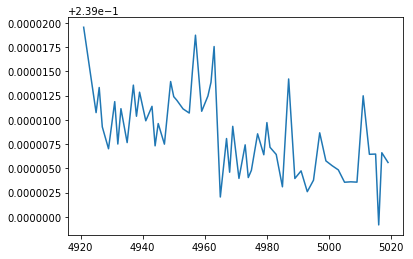

In [229]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [230]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-10-04 20:41:00,4921,NIST 200ppb,0.040145,0.027177,0.013943,0.600312,0.316735,0.354633,1.345909,0.19125,0.239020
2016-10-04 21:06:00,4923,NIST 350ppb,0.040147,0.027178,0.013945,0.600337,0.316745,0.354632,1.345911,0.19125,0.239010
2016-10-04 21:32:00,4925,NIST 200ppb,0.040147,0.027177,0.013947,0.600326,0.316734,0.354623,1.345915,0.19125,0.239011
2016-10-04 21:46:00,4926,NIST 200ppb,0.040142,0.027174,0.013945,0.600320,0.316734,0.354620,1.345927,0.19125,0.239013
2016-10-04 22:01:00,4927,NIST 200ppb,0.040146,0.027176,0.013945,0.600323,0.316736,0.354619,1.345922,0.19125,0.239009
2016-10-04 22:16:00,4928,NIST 350ppb,0.040148,0.027178,0.013946,0.600353,0.316744,0.354630,1.345929,0.19125,0.239009
2016-10-04 22:30:00,4929,NIST 200ppb,0.040145,0.027178,0.013947,0.600322,0.316733,0.354617,1.345940,0.19125,0.239007
2016-10-04 22:56:00,4931,NIST 200ppb,0.040147,0.027177,0.013947,0.600345,0.316744,0.354624,1.345951,0.19125,0.239012
2016-10-04 23:11:00,4932,NIST 200ppb,0.040145,0.027176,0.013946,0.600329,0.316737,0.354622,1.345936,0.19125,0.239008


In [231]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [232]:
drop_sum = [pd.Timestamp("2016-10-04 20:41:00"), pd.Timestamp("2016-10-04 21:06:00")]

In [233]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [234]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [235]:
data_mean_int_sum

112/118                   114/118  \
                                     mean       SD2 count      mean   
Sample                                                                
NIST + Cd ns 1 Sn TRU wash       0.040143       NaN     1  0.027177   
NIST 1000 ng Sn TRU PRE          0.040143  0.000003     2  0.027177   
NIST 1000 ng Sn TRU bf. PRE      0.040143  0.000002     2  0.027177   
NIST 150 ng Sn TRU               0.040144       NaN     1  0.027180   
NIST 200ppb                      0.040146  0.000006    59  0.027178   
NIST 350ppb                      0.040148  0.000006    12  0.027179   
NIST 500 ng Sn TRU               0.040143       NaN     1  0.027177   
ZH09-05 44.8_1_2 Sn TRU PRE      0.040145       NaN     1  0.027178   
ZH09-05 44.8_1_2 Sn TRU bf. PRE  0.040143       NaN     1  0.027178   

                                                      115/118                \
                                          SD2 count      mean           SD2   
Sample                                                                        
NIST + Cd ns 1 Sn TRU wash                NaN     1  0.013944           NaN   
NIST 1000 ng Sn TRU PRE          1.731144e-06     2  0.013945  1.492093e-06   
NIST 1000 ng Sn TRU bf. PRE      4.409684e-07     2  0.013944  7.780501e-07   
NIST 150 ng Sn TRU                        NaN     1  0.013946           NaN   
NIST 200ppb                      3.606525e-06    59  0.013946  1.937843e-06   
NIST 350ppb                      2.285652e-06    12  0.013947  1.276458e-06   
NIST 500 ng Sn TRU                        NaN     1  0.013944           NaN   
ZH09-05 44.8_1_2 Sn TRU PRE               NaN     1  0.013944           NaN   
ZH09-05 44.8_1_2 Sn TRU bf. PRE           NaN     1  0.013944           NaN   

                                        116/118  ...  119/118   120/118  \
                                count      mean  ...    count      mean   
Sample                                           ...                      
NIST + Cd ns 1 Sn TRU wash          1  0.600313  ...        1  1.345947   
NIST 1000 ng Sn TRU PRE             2  0.600320  ...        2  1.345975   
NIST 1000 ng Sn TRU bf. PRE         2  0.600318  ...        2  1.345974   
NIST 150 ng Sn TRU                  1  0.600324  ...        1  1.345972   
NIST 200ppb                        59  0.600331  ...       59  1.345960   
NIST 350ppb                        12  0.600348  ...       12  1.345946   
NIST 500 ng Sn TRU                  1  0.600311  ...        1  1.345950   
ZH09-05 44.8_1_2 Sn TRU PRE         1  0.600323  ...        1  1.345970   
ZH09-05 44.8_1_2 Sn TRU bf. PRE     1  0.600316  ...        1  1.345970   

                                                 122/118                      \
                                      SD2 count     mean           SD2 count   
Sample                                                                         
NIST + Cd ns 1 Sn TRU wash            NaN     1  0.19125           NaN     1   
NIST 1000 ng Sn TRU PRE          0.000005     2  0.19125  0.000000e+00     2   
NIST 1000 ng Sn TRU bf. PRE      0.000013     2  0.19125  5.551115e-17     2   
NIST 150 ng Sn TRU                    NaN     1  0.19125           NaN     1   
NIST 200ppb                      0.000033    59  0.19125  9.669913e-17    59   
NIST 350ppb                      0.000022    12  0.19125  1.004235e-16    12   
NIST 500 ng Sn TRU                    NaN     1  0.19125           NaN     1   
ZH09-05 44.8_1_2 Sn TRU PRE           NaN     1  0.19125           NaN     1   
ZH09-05 44.8_1_2 Sn TRU bf. PRE       NaN     1  0.19125           NaN     1   

                                  124/118                  
                                     mean       SD2 count  
Sample                                                     
NIST + Cd ns 1 Sn TRU wash       0.239005       NaN     1  
NIST 1000 ng Sn TRU PRE          0.239007  0.000003     2  
NIST 1000 ng Sn TRU bf. PRE      0.239006  0.000006     2  
NIST 150 n

In [236]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [237]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-10-04 20:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2016-10-04 21:06:00,0.000000,0.359176,0.447029,0.264743,0.298844,0.315570,0.096913,-0.009473,4.440892e-12,-0.226116,NIST 350ppb
2016-10-04 21:32:00,3.046613,0.874583,0.382963,2.178307,0.161581,-0.000898,-0.101308,-0.022278,-1.110223e-12,-0.238233,NIST 200ppb
2016-10-04 21:46:00,0.000000,-1.108658,-0.722072,-0.542667,-0.074181,-0.035402,-0.039308,0.059015,-1.110223e-12,0.139122,NIST 200ppb
2016-10-04 22:01:00,-1.014713,0.547669,0.026221,-0.529599,0.032899,0.071538,0.026897,-0.081387,2.220446e-12,-0.037876,NIST 200ppb
2016-10-04 22:16:00,0.000000,0.615141,0.444497,0.300555,0.513803,0.317927,0.337853,-0.019641,4.440892e-12,0.041804,NIST 350ppb
2016-10-04 22:30:00,0.000000,-0.312065,0.476956,0.216434,-0.201096,-0.215657,-0.131043,0.026974,-1.110223e-12,-0.148698,NIST 200ppb
2016-10-04 22:56:00,1.014096,0.603688,0.007019,0.725820,0.330295,0.275685,0.123010,0.093363,0.000000e+00,0.193026,NIST 200ppb
2016-10-04 23:11:00,0.000000,-0.241787,0.246751,-0.322273,-0.151767,-0.075381,-0.027228,-0.070240,-1.110223e-12,-0.167669,NIST 200ppb


In [238]:

date_list = [pd.Timestamp("2016-10-04 20:41:00"), 
             pd.Timestamp("2016-10-04 21:06:00"), 
             pd.Timestamp("2016-10-04 21:32:00"),  
             pd.Timestamp("2016-10-05 06:35:00")]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [239]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -20) & (df["Filenumber"] <= 20)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [240]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [241]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-10-04 21:46:00,4926,-1.108658,-0.722072,-0.542667,-0.074181,-0.035402,-0.039308,0.059015,-1.110223e-12,0.139122,NIST 200ppb
2016-10-04 22:01:00,4927,0.547669,0.026221,-0.529599,0.032899,0.071538,0.026897,-0.081387,2.220446e-12,-0.037876,NIST 200ppb
2016-10-04 22:16:00,4928,0.615141,0.444497,0.300555,0.513803,0.317927,0.337853,-0.019641,4.440892e-12,0.041804,NIST 350ppb
2016-10-04 22:30:00,4929,-0.312065,0.476956,0.216434,-0.201096,-0.215657,-0.131043,0.026974,-1.110223e-12,-0.148698,NIST 200ppb
2016-10-04 22:56:00,4931,0.603688,0.007019,0.725820,0.330295,0.275685,0.123010,0.093363,0.000000e+00,0.193026,NIST 200ppb
2016-10-04 23:11:00,4932,-0.241787,0.246751,-0.322273,-0.151767,-0.075381,-0.027228,-0.070240,-1.110223e-12,-0.167669,NIST 200ppb
2016-10-04 23:25:00,4933,-0.693208,-1.282806,-0.293260,-0.060802,-0.068883,-0.063508,-0.001366,-1.110223e-12,0.149381,NIST 200ppb
2016-10-04 23:40:00,4934,1.062692,1.376826,0.709626,0.511728,0.389832,0.054767,0.040820,0.000000e+00,0.004339,NIST 350ppb
2016-10-04 23:55:00,4935,0.737858,1.033664,0.467601,0.167327,0.089642,0.009630,0.033185,4.440892e-12,-0.197056,NIST 200ppb


In [242]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [243]:
epsilon_sum_all

112/118              114/118               \
                                   mean    SD2 count    mean    SD2 count   
Sample                                                                      
NIST + Cd ns 1 Sn TRU wash        0.079    NaN     1  -0.365    NaN     1   
NIST 1000 ng Sn TRU PRE          -0.310  0.548     2  -0.433  0.270     2   
NIST 1000 ng Sn TRU bf. PRE      -0.075  0.453     2   0.186  1.631     2   
NIST 150 ng Sn TRU                0.494    NaN     1   1.072    NaN     1   
NIST 200ppb                      -0.012  0.966    57   0.001  1.063    57   
NIST 350ppb                       0.485  0.571    11   0.579  0.676    11   
NIST 500 ng Sn TRU                0.043    NaN     1   0.301    NaN     1   
ZH09-05 44.8_1_2 Sn TRU PRE       0.012    NaN     1   0.388    NaN     1   
ZH09-05 44.8_1_2 Sn TRU bf. PRE   0.221    NaN     1   1.170    NaN     1   

                                115/118              116/118  ...  119/118  \
                                   mean    SD2 count    mean  ...    count   
Sample                                                        ...            
NIST + Cd ns 1 Sn TRU wash       -1.778    NaN     1  -0.034  ...        1   
NIST 1000 ng Sn TRU PRE          -0.302  1.446     2  -0.029  ...        2   
NIST 1000 ng Sn TRU bf. PRE      -1.149  1.110     2  -0.011  ...        2   
NIST 150 ng Sn TRU                0.244    NaN     1   0.103  ...        1   
NIST 200ppb                      -0.006  1.431    57  -0.001  ...       57   
NIST 350ppb                       0.014  1.011    11   0.264  ...       11   
NIST 500 ng Sn TRU               -0.645    NaN     1  -0.167  ...        1   
ZH09-05 44.8_1_2 Sn TRU PRE      -1.284    NaN     1  -0.067  ...        1   
ZH09-05 44.8_1_2 Sn TRU bf. PRE  -1.535    NaN     1  -0.102  ...        1   

                                120/118              122/118             \
                                   mean    SD2 count    mean  SD2 count   
Sample                                                                    
NIST + Cd ns 1 Sn TRU wash       -0.207    NaN     1     0.0  NaN     1   
NIST 1000 ng Sn TRU PRE           0.001  0.064     2    -0.0  0.0     2   
NIST 1000 ng Sn TRU bf. PRE       0.009  0.020     2    -0.0  0.0     2   
NIST 150 ng Sn TRU               -0.020    NaN     1     0.0  NaN     1   
NIST 200ppb                       0.000  0.150    57    -0.0  0.0    57   
NIST 350ppb                      -0.101  0.138    11     0.0  0.0    11   
NIST 500 ng Sn TRU               -0.193    NaN     1     0.0  NaN     1   
ZH09-05 44.8_1_2 Sn TRU PRE      -0.026    NaN     1    -0.0  NaN     1   
ZH09-05 44.8_1_2 Sn TRU bf. PRE   0.030    NaN     1     0.0  NaN     1   

                                124/118               
                                   mean    SD2 count  
Sample                                                
NIST + Cd ns 1 Sn TRU wash       -0.116    NaN     1  
NIST 1000 ng Sn TRU PRE           0.008  0.425     2  
NIST 1000 ng Sn TRU bf. PRE       0.112  0.223     2  
NIST 150 ng Sn TRU                0.061    NaN     1  
NIST 200ppb                       0.001  0.352    57  
NIST 350ppb                      -0.072  0.153    11  
NIST 500 ng Sn TRU               -0.153    NaN     1  
ZH09-05 44.8_1_2 Sn TRU PRE      -0.308    NaN     1  
ZH09-05 44.8_1_2 Sn TRU bf. PRE  -0.002    NaN     1  

[9 rows x 27 columns]

In [244]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [182]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [183]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [245]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [246]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [247]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [248]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')